# Start Mode Comparison (Head vs. K-means)

This notebook instantiates `make_ais_dataset` twice: once with the classic `start_mode='head'`
and once with `start_mode='kmeans'`. It samples trajectory windows from
`data/map_reduced/train` and visualizes the initial latitude/longitude positions to show
how cluster-aware starts diversify sequence extraction.

In [65]:
from pathlib import Path
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch
import sys

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError('Cannot locate project root (missing src/).')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_ROOT = PROJECT_ROOT / 'data' / 'map_reduced' / 'train'
print(f'Project root: {PROJECT_ROOT}')
print(f'Data dir: {DATA_ROOT}')

Project root: /Users/christianrand/Documents/Documents - Christian’s MacBook Pro/MSc Business Analytics/Deep Learning/AIS-MDA
Data dir: /Users/christianrand/Documents/Documents - Christian’s MacBook Pro/MSc Business Analytics/Deep Learning/AIS-MDA/data/map_reduced/train


In [66]:
from src.utils.datasets_V3 import make_ais_dataset
from src.preprocessing.preprocessing_V2 import LAT_MIN, LAT_MAX, LON_MIN, LON_MAX

WINDOW = 64
HORIZON = 12
KMEANS_CFG = {
    'n_clusters': 32,
    'samples_per_traj': 128,
    'max_points': 200000,
    'n_init': 10,
    'random_state': 42,
}

ds_head = make_ais_dataset(str(DATA_ROOT), window=WINDOW, horizon=HORIZON,
                           output_features=2, filter_short=True,
                           start_mode='head', kmeans_config=None)
ds_kmeans = make_ais_dataset(str(DATA_ROOT), window=WINDOW, horizon=HORIZON,
                             output_features=2, filter_short=True,
                             start_mode='kmeans', kmeans_config=KMEANS_CFG)
print(f'Head-start dataset items: {len(ds_head)}')
print(f'K-means dataset items: {len(ds_kmeans)}')

Head-start dataset items: 673
K-means dataset items: 673


In [67]:
def denormalize_lat_lon(lat_lon):
    if lat_lon.size == 0:
        return lat_lon
    lat = lat_lon[:, 0] * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = lat_lon[:, 1] * (LON_MAX - LON_MIN) + LON_MIN
    return np.column_stack([lat, lon])

def sample_start_coords(dataset, n_samples=256):
    coords = []
    upper = min(len(dataset), n_samples)
    for idx in range(upper):
        seq, mask, *_ = dataset[idx]
        seq = seq.numpy()
        starts = seq[0, :2][None, :]
        coords.append(starts)
    if not coords:
        return np.empty((0, 2))
    return denormalize_lat_lon(np.concatenate(coords, axis=0))

start_head = sample_start_coords(ds_head, 400)
start_kmeans = sample_start_coords(ds_kmeans, 400)
print(f'Sampled {len(start_head)} head-start windows, {len(start_kmeans)} k-means windows')

Sampled 400 head-start windows, 400 k-means windows


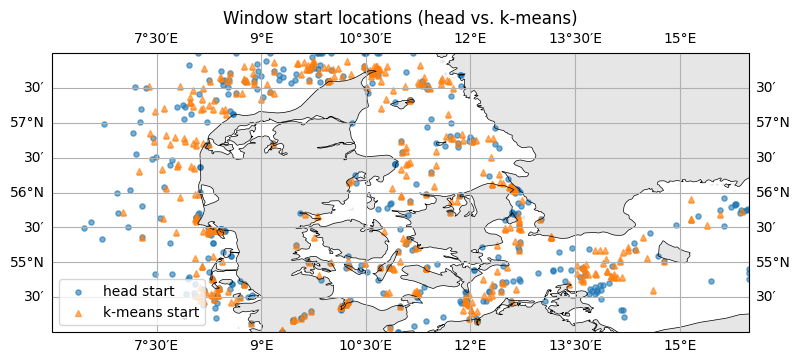

In [68]:
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.LAND, facecolor='0.9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.scatter(start_head[:, 1], start_head[:, 0], s=14, c='tab:blue', alpha=0.6,
           transform=ccrs.PlateCarree(), label='head start')
ax.scatter(start_kmeans[:, 1], start_kmeans[:, 0], s=18, c='tab:orange', alpha=0.6, marker='^',
           transform=ccrs.PlateCarree(), label='k-means start')
ax.set_title('Window start locations (head vs. k-means)')
ax.legend(loc='lower left')
plt.show()

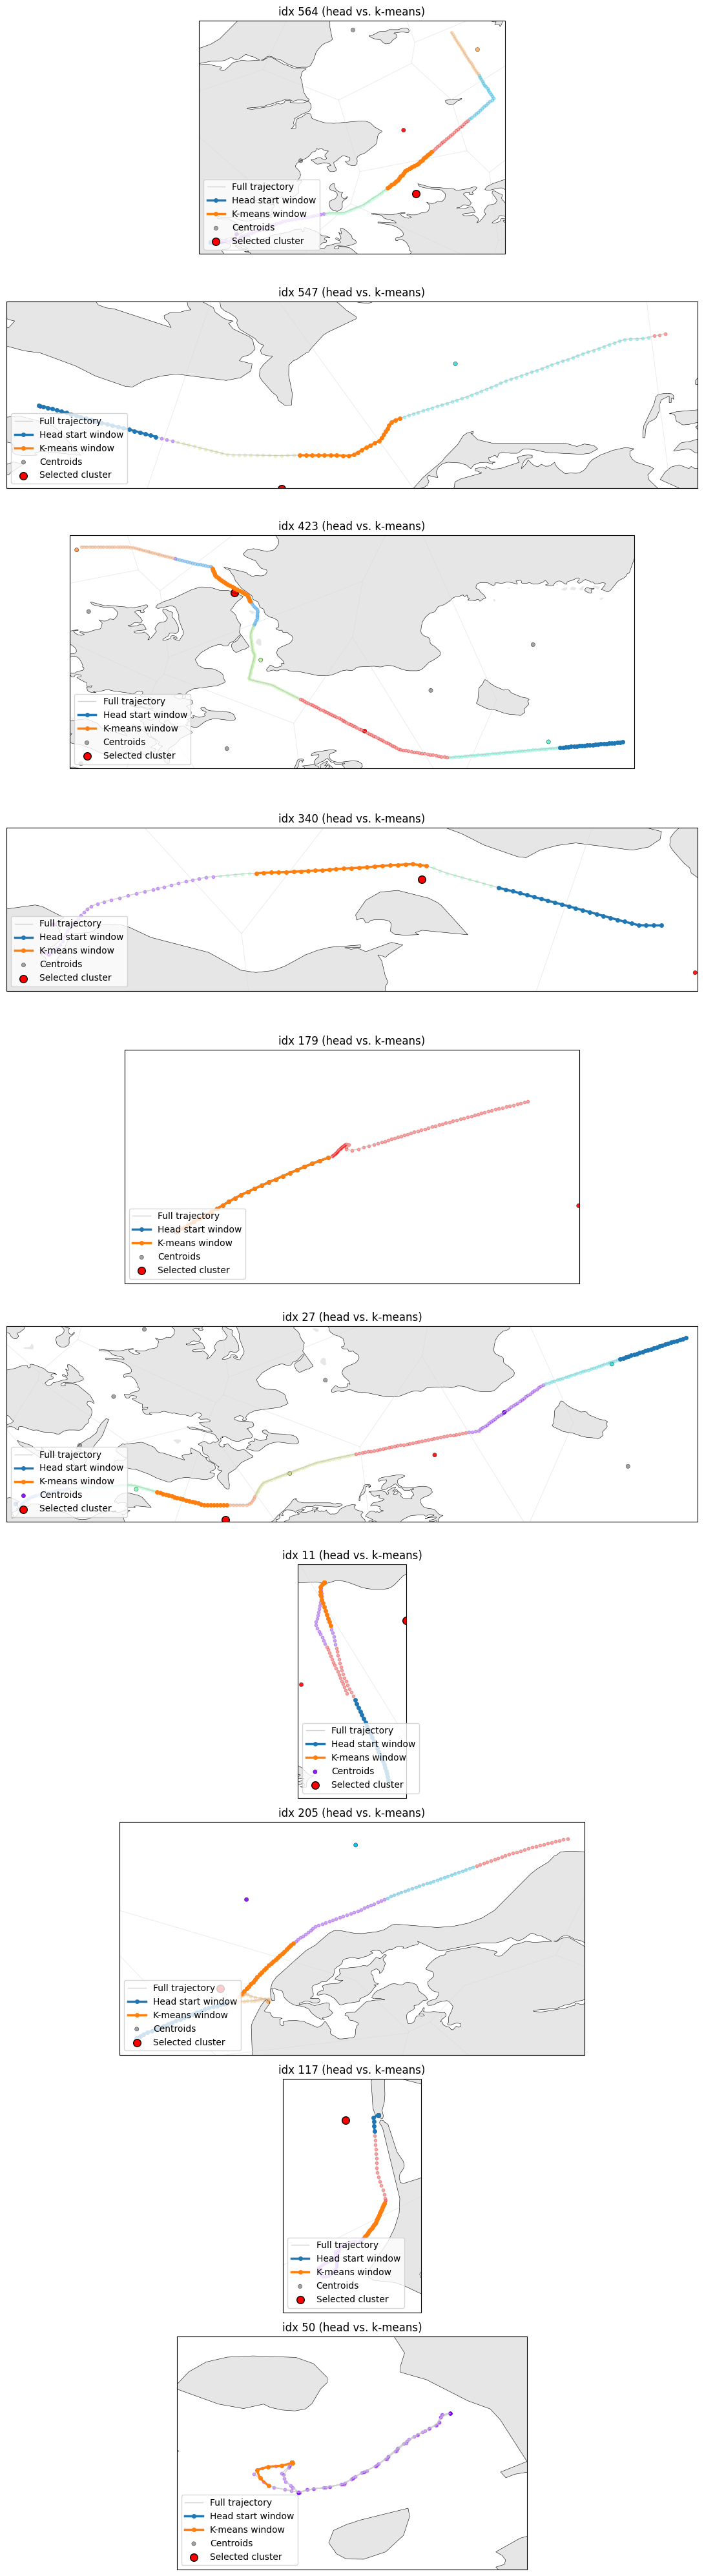

In [69]:
from pathlib import Path as _Path
import pickle
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.cm as cm

def get_window_path(dataset, idx):
    seq, mask, *_ = dataset[idx]
    seq_arr = seq.numpy()
    valid = mask.numpy().astype(bool)
    lat_lon = seq_arr[:np.sum(valid), :2]
    return denormalize_lat_lon(lat_lon), seq_arr[:np.sum(valid), :2].astype(np.float32)

def get_full_traj(dataset, idx):
    orig_idx = dataset._valid_indices[idx]
    fname = dataset.file_list[orig_idx]
    path = _Path(dataset.data_dir) / fname
    with open(path, 'rb') as f:
        traj = pickle.load(f)["traj"]
    return denormalize_lat_lon(traj[:, :2].astype(np.float32)), traj[:, :2].astype(np.float32)

rng = np.random.default_rng(0)
sample_indices = rng.choice(len(ds_head), size=min(10, len(ds_head)), replace=False)
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(11, 4 * len(sample_indices)), subplot_kw={'projection': ccrs.PlateCarree()})
if len(sample_indices) == 1:
    axes = np.array([axes])
centers_norm = getattr(ds_kmeans, '_centroids', None)
model = getattr(ds_kmeans, '_kmeans_model', None)
centers_deg = denormalize_lat_lon(centers_norm) if centers_norm is not None else None
centers_lonlat = np.column_stack([centers_deg[:, 1], centers_deg[:, 0]]) if centers_deg is not None else None
vor = Voronoi(centers_lonlat) if centers_lonlat is not None and len(centers_lonlat) >= 4 else None
for row, idx in enumerate(sample_indices):
    (full_traj_deg, full_traj_norm) = get_full_traj(ds_head, idx)
    if model is not None:
        full_traj_norm = full_traj_norm.astype(model.cluster_centers_.dtype, copy=False)
    (win_head_deg, _) = get_window_path(ds_head, idx)
    (win_kmeans_deg, win_kmeans_norm) = get_window_path(ds_kmeans, idx)
    if model is not None:
        win_kmeans_norm = win_kmeans_norm.astype(model.cluster_centers_.dtype, copy=False)
    ax = axes[row]
    lat_min, lat_max = full_traj_deg[:, 0].min() - 0.1, full_traj_deg[:, 0].max() + 0.1
    lon_min, lon_max = full_traj_deg[:, 1].min() - 0.1, full_traj_deg[:, 1].max() + 0.1
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    if vor is not None:
        for ridge in vor.ridge_vertices:
            if -1 in ridge:
                continue
            pts = vor.vertices[ridge]
            ax.plot(pts[:, 0], pts[:, 1], color='0.85', linewidth=0.6, alpha=0.6, transform=ccrs.PlateCarree())
    ax.plot(full_traj_deg[:, 1], full_traj_deg[:, 0], '-', color='0.75', linewidth=1.0, alpha=0.7, transform=ccrs.PlateCarree(), label='Full trajectory')
    ax.plot(win_head_deg[:, 1], win_head_deg[:, 0], '-o', linewidth=2.5, color='tab:blue', markersize=4, transform=ccrs.PlateCarree(), label='Head start window')
    ax.plot(win_kmeans_deg[:, 1], win_kmeans_deg[:, 0], '-o', linewidth=2.5, color='tab:orange', markersize=4, transform=ccrs.PlateCarree(), label='K-means window')
    if centers_deg is not None and model is not None:
        labels = model.predict(full_traj_norm)
        unique_labels = np.unique(labels)
        colors = cm.rainbow(np.linspace(0, 1, max(1, len(unique_labels))))
        label_color = {lab: color for lab, color in zip(unique_labels, colors)}
        for lab, color in label_color.items():
            mask_label = labels == lab
            segment = full_traj_deg[mask_label]
            ax.scatter(segment[:, 1], segment[:, 0], s=10, color=color, alpha=0.35, transform=ccrs.PlateCarree())
        center_colors = np.array(['0.6'] * len(centers_deg), dtype=object)
        for lab, color in label_color.items():
            if lab < len(center_colors):
                center_colors[lab] = color
        ax.scatter(centers_deg[:, 1], centers_deg[:, 0], s=20, c=center_colors, edgecolors='k', linewidths=0.3, alpha=0.9, transform=ccrs.PlateCarree(), label='Centroids')
        selected_label = None
        if len(win_kmeans_norm) > 0:
            selected_label = int(model.predict(win_kmeans_norm[:1])[0])
        if selected_label is not None and selected_label < len(centers_deg):
            ax.scatter(centers_deg[selected_label, 1], centers_deg[selected_label, 0], s=70, c='red', edgecolors='black', linewidths=1.0, transform=ccrs.PlateCarree(), label='Selected cluster')
    ax.set_title(f'idx {idx} (head vs. k-means)')
    ax.legend(loc='lower left')
plt.tight_layout()
plt.show()


## Notes
- The k-means dataset fits centroids directly from the train split each time this notebook runs.
- Adjust `sample_idx` or `WINDOW/HORIZON` to inspect different projections of the same voyage.
- Ensure Cartopy can download Natural Earth assets the first time you render the maps.

## Dataset-level start distribution diagnostics
The cell below compares global start locations between head and k-means sampling using density plots and cluster coverage metrics.

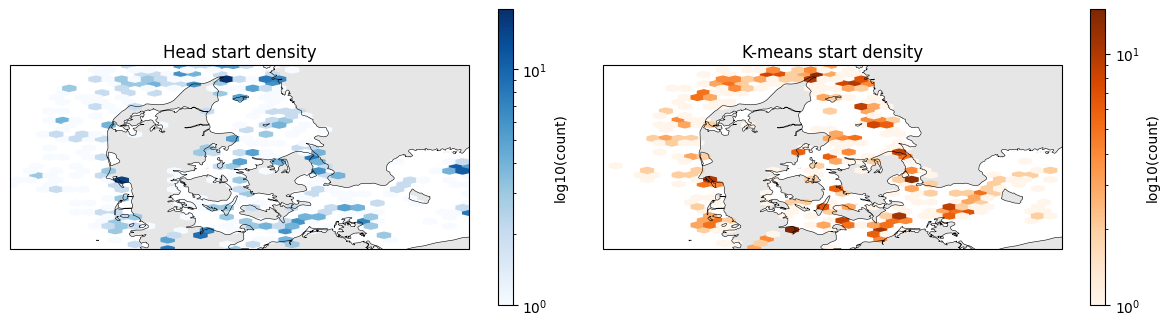

--- Cluster coverage metrics ---
Head mode: 32 / 32 clusters touched; entropy=3.346; mean dist=0.0462
K-means mode: 32 / 32 clusters touched; entropy=3.335; mean dist=0.0288
Clusters with largest positive coverage gain (k-means vs head):
  cluster 0: +14 starts near lat=55.21, lon=14.28
  cluster 4: +11 starts near lat=56.73, lon=12.04
  cluster 19: +11 starts near lat=55.48, lon=12.78
  cluster 25: +8 starts near lat=54.85, lon=13.70
  cluster 18: +7 starts near lat=57.15, lon=11.79


In [70]:
# Quantitative comparison of start distributions
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

def collect_start_positions(dataset, max_items=None):
    coords_deg = []
    coords_norm = []
    total = len(dataset) if max_items is None else min(len(dataset), max_items)
    for idx in range(total):
        seq, mask, *_ = dataset[idx]
        seq_arr = seq.numpy()
        valid = int(mask.sum().item())
        if valid == 0:
            continue
        start_norm = seq_arr[0, :2]
        coords_norm.append(start_norm)
        coords_deg.append(denormalize_lat_lon(start_norm[None, :])[0])
    return np.asarray(coords_deg), np.asarray(coords_norm)

head_deg, head_norm = collect_start_positions(ds_head)
kmeans_deg, kmeans_norm = collect_start_positions(ds_kmeans)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
for ax, coords, title, cmap in [
        (axes[0], head_deg, 'Head start density', 'Blues'),
        (axes[1], kmeans_deg, 'K-means start density', 'Oranges')
    ]:
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    hb = ax.hexbin(coords[:, 1], coords[:, 0], gridsize=35, cmap=cmap, bins='log', mincnt=1, transform=ccrs.PlateCarree())
    ax.set_title(title)
    plt.colorbar(hb, ax=ax, orientation='vertical', shrink=0.8, label='log10(count)')
plt.tight_layout()
plt.show()

model = getattr(ds_kmeans, '_kmeans_model', None)
if model is not None and len(head_norm) > 0 and len(kmeans_norm) > 0:
    def cluster_stats(norm_coords):
        norm_coords = norm_coords.astype(model.cluster_centers_.dtype, copy=False)
        labels = model.predict(norm_coords)
        counts = np.bincount(labels, minlength=len(model.cluster_centers_))
        probs = counts[counts > 0] / counts.sum()
        coverage = np.count_nonzero(counts)
        ent = float(-np.sum(probs * np.log(probs)))
        dists = np.linalg.norm(norm_coords - model.cluster_centers_[labels], axis=1)
        return labels, counts, coverage, ent, float(dists.mean())
    head_labels, head_counts, head_cov, head_ent, head_mean_dist = cluster_stats(head_norm)
    km_labels, km_counts, km_cov, km_ent, km_mean_dist = cluster_stats(kmeans_norm)
    print('--- Cluster coverage metrics ---')
    print(f'Head mode: {head_cov} / {len(model.cluster_centers_)} clusters touched; entropy={head_ent:.3f}; mean dist={head_mean_dist:.4f}')
    print(f'K-means mode: {km_cov} / {len(model.cluster_centers_)} clusters touched; entropy={km_ent:.3f}; mean dist={km_mean_dist:.4f}')
    diff = (km_counts - head_counts)
    top = np.argsort(diff)[-5:][::-1]
    print('Clusters with largest positive coverage gain (k-means vs head):')
    for cid in top:
        if diff[cid] <= 0:
            continue
        lat_lon = denormalize_lat_lon(model.cluster_centers_[cid][None, :2])[0]
        print(f'  cluster {cid}: +{diff[cid]} starts near lat={lat_lon[0]:.2f}, lon={lat_lon[1]:.2f}')
else:
    print('K-means model not available; skipping coverage metrics.')


notes:
Added K-means–aware start selection to AISDatasetBase: each split now fits its own centroid model (normalizing to float64 for stability) and, when start_mode: kmeans, shifts the window to the closest valid point within a randomly chosen visited cluster. start_mode: head preserves legacy behavior. Configs and train_traj_V3.py gained start_mode/kmeans knobs.

Built notebooks/kmeans_map_reduced.ipynb to load the map_reduced train/val/test pickles, sample lat/lon windows via make_ais_dataset, run elbow plots, K-means clustering, Voronoi visualizations, and render scatter plots/frequency summaries in both normalized space and on a Cartopy basemap.

Created notebooks/start_mode_comparison.ipynb to contrast head vs. k-means sampling: loading both datasets, denormalizing to degrees, plotting hexbin start densities, overlaying per-trajectory comparisons (full voyage, both windows, cluster boundaries via Voronoi), and exposing helper code to inspect how windows traverse clusters. Handling was added for centroid highlighting, thicker path rendering, and dtype casting for sklearn.

Appended a dataset-level diagnostics cell that collects every start point to compare spatial density (via hexbin heatmaps) and cluster coverage metrics (clusters touched, entropy, mean distance, biggest gains) between head and k-means sampling.

Together, these changes let you toggle the new sampler in configs, inspect its effect visually per voyage, and quantify de-biasing across the entire dataset.

### Sequence length comparison
The cell below checks how many valid timesteps (mask sum) each dataset yields after applying head vs. k-means starting points.

Head mode: min=3 median=12.0 max=18
K-means mode: min=3 median=12.0 max=18


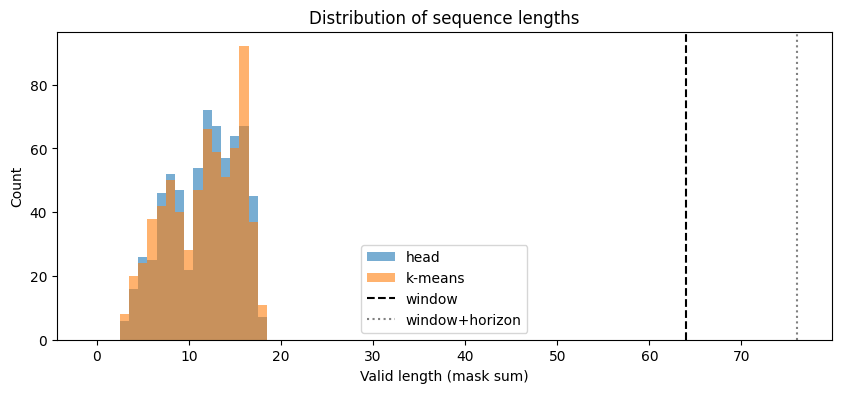

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def collect_lengths(dataset):
    lengths = []
    for idx in range(len(dataset)):
        _seq, mask, *_ = dataset[idx]
        lengths.append(int(mask.sum().item()))
    return np.asarray(lengths)

head_lengths = collect_lengths(ds_head)
kmeans_lengths = collect_lengths(ds_kmeans)
print(f'Head mode: min={head_lengths.min()} median={np.median(head_lengths)} max={head_lengths.max()}')
print(f'K-means mode: min={kmeans_lengths.min()} median={np.median(kmeans_lengths)} max={kmeans_lengths.max()}')
plt.figure(figsize=(10,4))
bins = np.arange(0, max(head_lengths.max(), kmeans_lengths.max()) + 2) - 0.5
plt.hist(head_lengths, bins=bins, alpha=0.6, label='head', color='tab:blue')
plt.hist(kmeans_lengths, bins=bins, alpha=0.6, label='k-means', color='tab:orange')
plt.axvline(WINDOW, color='k', linestyle='--', label='window')
plt.axvline(WINDOW+HORIZON, color='gray', linestyle=':', label='window+horizon')
plt.xlabel('Valid length (mask sum)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of sequence lengths')
plt.show()
